In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import backend as K
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D
import matplotlib.pyplot as plt


import pickle
import os
import splitfolders
import warnings
import zipfile
import PIL

os.environ["KAGGLE_USERNAME"] = #"INSERT YOUR USERNAME"
os.environ["KAGGLE_KEY"] = #"INSERT YOUR KEY"

from kaggle.api.kaggle_api_extended import KaggleApi

warnings.filterwarnings("ignore")

In [4]:
api = KaggleApi()
api.authenticate()

api.dataset_download_files("harishkumardatalab/food-image-classification-dataset", path=".")

In [5]:
with zipfile.ZipFile("food-image-classification-dataset.zip", "r") as z:
    z.extractall(".")

In [ ]:
path = './Food Classification dataset'
output = f"{path} splitted"

In [7]:
#Number of categories
len(os.listdir(path))

34

In [8]:
#spliting data into, training, validation, and test
splitfolders.ratio(path, seed=1337, output=output, ratio=(0.6, 0.2, 0.2))

Copying files: 23873 files [00:12, 1930.90 files/s]


In [10]:
# This was an imbalaced dataset, hence to better understand model performance, it was used F1-Score
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [11]:
# Part 2 - Fitting the CNN to the images

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

validation_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load and preprocess the training set
training_set = train_datagen.flow_from_directory(f'{output}/train',
    target_size=(224, 224),
    batch_size=128,
    class_mode='categorical'
)

# Load and preprocess the validation set
validation_set = validation_datagen.flow_from_directory(f'{output}/val',
    target_size=(224, 224),
    batch_size=128,
    class_mode='categorical'
)



Found 14316 images belonging to 34 classes.
Found 4765 images belonging to 34 classes.


In [14]:
# AGG16 architecture
# https://www.mathworks.com/help/deeplearning/ref/vgg16.html

# Define a callback
save_ck = callbacks.ModelCheckpoint('.mdl_wt.hdf5',save_best_only=True,monitor='val_loss',mode='min')

# Initialize a sequential model
vgg_model = Sequential()

# Load the VGG16 model without the top classification layer, using pre-trained ImageNet weights
vgg_base_model = VGG16(include_top = False, weights="imagenet", input_shape = (224,224,3))
print(f'Number of layers in VGG16 : {len(vgg_base_model.layers)}')

# Set the base model to be trainable
vgg_base_model.trainable = True

# Freeze the first  15 layers of the base model to preserve the pre-trained features
for layer in vgg_base_model.layers[:15]:
    layer.trainable = False

# Add the base model to the new model
vgg_model.add(vgg_base_model)
# Add a Global Average Pooling layer followed by a dense layer with softmax activation for classification
vgg_model.add(GlobalAveragePooling2D())
vgg_model.add(Dense(units = 34, activation = 'softmax'))
vgg_model.summary()

# Compile the model with Adam optimizer, categorical crossentropy loss, and the calculated F1-Score
vgg_model.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.0001) , loss = 'categorical_crossentropy' , metrics = [f1_m])
# Train the model
vgg = vgg_model.fit(training_set,
                    batch_size = 128,
                    epochs = 10,
                    validation_data = validation_set,
                    callbacks=save_ck)

Number of layers in VGG16 : 19
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_1 (Dense)             (None, 34)                17442     
                                                                 
Total params: 14732130 (56.20 MB)
Trainable params: 7096866 (27.07 MB)
Non-trainable params: 7635264 (29.13 MB)
_________________________________________________________________
Epoch 1/10
112/112 [==============================] - 323s 3s/step - loss: 2.2529 - f1_m: 0.2388 - val_loss: 1.4919 - val_f1_m: 0.4919
Epoch 2/10
112/112 [====================

In [24]:
#Save model in a h5 file
vgg.save('vgg_foodclass.h5', save_format='h5')

In [17]:
#Load and preprocess the test set
test_set = test_datagen.flow_from_directory(f'{output}/test',
    target_size=(224, 224),
    batch_size=128,
    class_mode='categorical',
    shuffle=False
)

Found 4792 images belonging to 34 classes.


In [19]:
# Evaluate the model on the test set
evaluation_results = vgg_model.evaluate(test_set)
print(f'Test Loss: {evaluation_results[0]}, Test F1: {evaluation_results[1]}')

38/38 [==============================] - 32s 835ms/step - loss: 0.8074 - f1_m: 0.7746
Test Loss: 0.8074254989624023, Test F1: 0.774620771408081


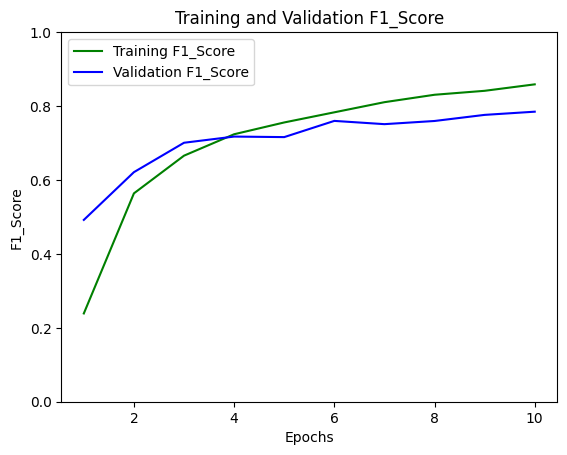

In [28]:
# Plot training and validation F1-Score
accuracy = vgg.history['f1_m']
val_accuracy = vgg.history['val_f1_m']
epochs = range(1, len(accuracy) + 1)

plt.ylim([0, 1])
plt.plot(epochs, accuracy, 'g', label='Training F1_Score')
plt.plot(epochs, val_accuracy, 'b', label='Validation F1_Score')
plt.title('Training and Validation F1_Score')
plt.xlabel('Epochs')
plt.ylabel('F1_Score')
plt.legend()
plt.show()

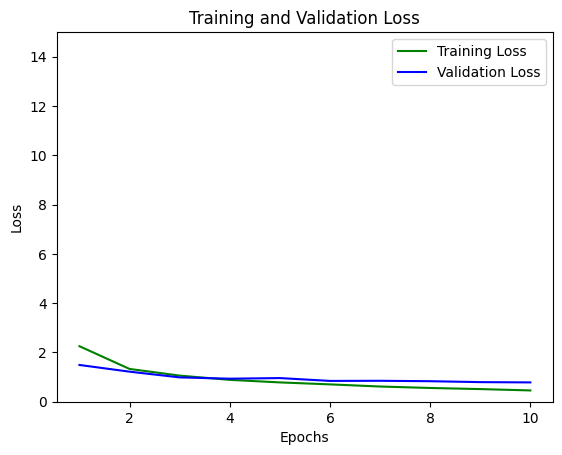

In [33]:
# Plot training and validation Loss
loss = vgg.history['loss']
val_loss = vgg.history['val_loss']
epochs = range(1, len(accuracy) + 1)

plt.ylim([0, 15])
plt.plot(epochs, loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [31]:
# Assuming you have more than two classes, use argmax to get predicted class indices
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = vgg_model.predict_generator(test_set)
predicted_classes = np.argmax(Y_pred, axis=1)

# Print confusion matrix
print('Confusion Matrix')
print(confusion_matrix(test_set.classes, predicted_classes))

# Print classification report
target_names = ['apple_pie', 'Baked Potato', 'burger', 'butter_naan', 'chai', 'chapati', 'cheesecake', 'chicken_curry', 'chole_bhature', 'Crispy Chicken', 'dal_makhani', 'dhokla', 'Donut', 'fried_rice', 'Fries', 'Hot Dog', 'ice_cream', 'idli', 'jalebi', 'kaathi_rolls', 'kadai_paneer', 'kulfi', 'masala_dosa', 'momos', 'omelette', 'paani_puri', 'pakode', 'pav_bhaji', 'pizza', 'samosa', 'Sandwich', 'sushi', 'Taco', 'Taquito']
print('Classification Report')
print(classification_report(test_set.classes, predicted_classes, target_names=target_names))

Confusion Matrix
[[263   2   4 ...   0   2   2]
 [  8 224   0 ...   0   2   2]
 [  3   0 270 ...   0   0   1]
 ...
 [  6   0   0 ...  27   0   0]
 [  0   0   0 ...   0  43   0]
 [  1   0   3 ...   0   1 157]]
Classification Report
                precision    recall  f1-score   support

     apple_pie       0.78      0.88      0.82       300
  Baked Potato       0.81      0.75      0.78       300
        burger       0.92      0.90      0.91       300
   butter_naan       0.93      0.82      0.87       300
          chai       0.91      0.76      0.83       311
       chapati       0.91      0.66      0.77       300
    cheesecake       0.75      0.65      0.70       300
 chicken_curry       0.87      0.72      0.79       300
 chole_bhature       0.55      0.73      0.63       200
Crispy Chicken       0.65      0.88      0.75        67
   dal_makhani       0.88      0.45      0.60        62
        dhokla       0.82      0.86      0.84        70
         Donut       0.73      0.80     